# Introduction

In this chapter, we employ the XGBoost model to predict the Federal Funds Rate (FEDFUNDS) as part of achieving the project's objectives. XGBoost has been demonstrated to outperform existing systems across a wide range of machine learning tasks, including regression, classification, and ranking. Its state-of-the-art performance is attributed to its efficient computation techniques and system-level optimizations, which significantly reduce training time while maintaining high accuracy (Chen & Guestrin, 2016).

The key stages of this work are outlined as follows:

Data Preprocessing: Historical macroeconomic data were preprocessed to address missing values, transform variables, standardize features, and construct lagged features to capture temporal dependencies and patterns within the time series.

Dimensionality Reduction: Principal Component Analysis (PCA) was employed to reduce the dimensionality of the input features, ensuring that the majority of the data variance was preserved while simplifying the model's input space.

Model Training and Validation: The XGBoost model was utilized for training, accompanied by comprehensive hyperparameter tuning to optimize its performance. To ensure robust evaluation, a walk-forward validation strategy was adopted to assess the model’s predictive capabilities on unseen data.

Performance Evaluation: The model’s accuracy and reliability were assessed using evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

In conclusion, while the model demonstrates suboptimal performance when evaluated using the R^2 metric, it achieves strong results based on the selected evaluation criteria. These findings suggest that the model exhibits good predictive accuracy and generalizability, making it suitable for the task of forecasting the Federal Funds Rate.

# Data Preprocessing

The data preprocessing section was mainly adapted from the code provided by Professor C-Y (Eric) NG in the Econ 5060 course. Additionally, in this section, we incorporated the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) analyses to assess whether the lag of one period aligns with the intrinsic characteristics of the data (Box et al., 2015).

In [61]:
#Standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [62]:
# Imports data
macro = pd.read_csv(r'C:\Users\MaYu\Desktop\5060 group\US FRED-MD Macro Dataset.csv', header=0, index_col=0, parse_dates=True)
macro.shape

(773, 127)

In [63]:
macro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2442.158,2293.2,17.272,2.922664e+05,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,17821.000,14623.3,130.028,1.581882e+06,692501.00000,102.5080,101.2863,101.3295,102.0755,104.8646,...,114.885,134.903,28.91,33.44,25.82,64.9,383384.74,720635.04,5505.6964,20.2269
2023-02-01,17839.528,14622.7,129.991,1.575290e+06,687942.00000,102.5023,101.0873,101.1983,102.1753,105.0877,...,115.279,135.397,28.98,33.61,25.81,67.0,385165.01,718917.35,5491.3981,20.2141
2023-03-01,17885.887,14664.3,129.948,1.560472e+06,681673.00000,102.6521,101.0102,101.1678,102.4580,103.9786,...,114.930,135.782,29.12,33.79,25.95,62.0,388912.72,719670.11,5366.2449,22.0446


In [64]:
# Imports data
tran_code = pd.read_csv(r'C:\Users\MaYu\Desktop\5060 group\US FRED-data_transform_code.csv', header=0, index_col=0, parse_dates=False)
tran_code.shape

(1, 127)

In [65]:
tran_code

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Symbol,,,,,,,,,,,,,,,,,,,,,
tcode,5,5,5,5,5,5,5,5,5,5,...,6,6,6,6,6,2,6,6,6,1


In [66]:
def data_transform(x, tran_code):
    
    if tran_code == 1:
        x_tr = x        
        
    elif tran_code == 2:
        x_tr = x.diff()
            
    elif tran_code == 3:
        x_tr = x.diff().diff()
        
    elif tran_code == 4:
        x_tr = np.log(x)
        
    elif tran_code == 5:
        x_tr = np.log(x).diff()*100
    
    elif tran_code == 6:
        x_tr = np.log(x).diff().diff()*100
    
    else:
        x_tr = (x.pct_change()-1)*100
    
    return x_tr    

In [67]:
macro_tr=[]

for col in macro.columns:
    tr_code = tran_code[col].values
    data_tr = data_transform(macro[col], tr_code)
    macro_tr.append(data_tr)

macro_tr = pd.DataFrame(macro_tr).T

In [68]:
macro_tr

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.393140,0.361286,1.036756,0.735762,0.730985,1.939060,1.340746,0.862504,0.731050,0.523479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.643011,0.735934,0.941009,-0.342293,0.832120,1.430562,0.603538,0.489413,0.000000,1.939253,...,-0.112407,0.026180,-0.002184,-0.814665,0.481883,NaN,0.492915,0.413844,-1.479236,NaN
1959-04-01,0.649412,0.704864,-0.363947,1.992210,0.061571,2.107542,1.433800,1.454467,1.565020,0.638320,...,0.134899,0.175237,-0.002163,1.220345,-0.488953,NaN,1.213403,0.673430,2.492924,NaN
1959-05-01,0.576311,0.661646,1.200535,0.679731,0.780340,1.495451,0.826987,0.958168,0.477012,2.014866,...,-0.168653,-0.193673,-0.002143,-0.408972,-0.481929,NaN,0.282830,0.202040,-1.534223,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,0.087570,0.130699,1.316033,0.190398,2.764501,1.003181,0.343776,-0.014901,-0.334291,0.217564,...,1.425376,0.033243,0.170724,-0.004386,0.309575,5.2,0.071035,0.049043,-0.142513,20.2269
2023-02-01,0.103913,-0.004103,-0.028459,-0.417590,-0.660515,-0.005561,-0.196666,-0.129562,0.097723,0.212525,...,-0.416042,-0.224790,-0.417543,-0.152983,-0.621376,2.1,-0.237727,-0.068985,-0.121427,20.2141
2023-03-01,0.259530,0.284085,-0.033085,-0.945104,-0.915446,0.146036,-0.076300,-0.030143,0.276299,-1.061013,...,-0.645568,-0.081575,0.240091,0.027041,0.579697,-5.0,0.505030,0.343295,-2.045412,22.0446


In [69]:
target_column = 'FEDFUNDS'
EFFR = macro_tr[target_column]
macro_tr = macro_tr.drop(columns=[target_column])
macro_tr[target_column] = EFFR
EFFR

sasdate
1959-01-01     NaN
1959-02-01   -0.05
1959-03-01    0.37
1959-04-01    0.16
1959-05-01   -0.06
              ... 
2023-01-01    0.23
2023-02-01    0.24
2023-03-01    0.08
2023-04-01    0.18
2023-05-01    0.23
Name: FEDFUNDS, Length: 773, dtype: float64

In [70]:
macro_tr

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,FEDFUNDS
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.393140,0.361286,1.036756,0.735762,0.730985,1.939060,1.340746,0.862504,0.731050,0.523479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05
1959-03-01,0.643011,0.735934,0.941009,-0.342293,0.832120,1.430562,0.603538,0.489413,0.000000,1.939253,...,0.026180,-0.002184,-0.814665,0.481883,NaN,0.492915,0.413844,-1.479236,NaN,0.37
1959-04-01,0.649412,0.704864,-0.363947,1.992210,0.061571,2.107542,1.433800,1.454467,1.565020,0.638320,...,0.175237,-0.002163,1.220345,-0.488953,NaN,1.213403,0.673430,2.492924,NaN,0.16
1959-05-01,0.576311,0.661646,1.200535,0.679731,0.780340,1.495451,0.826987,0.958168,0.477012,2.014866,...,-0.193673,-0.002143,-0.408972,-0.481929,NaN,0.282830,0.202040,-1.534223,NaN,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,0.087570,0.130699,1.316033,0.190398,2.764501,1.003181,0.343776,-0.014901,-0.334291,0.217564,...,0.033243,0.170724,-0.004386,0.309575,5.2,0.071035,0.049043,-0.142513,20.2269,0.23
2023-02-01,0.103913,-0.004103,-0.028459,-0.417590,-0.660515,-0.005561,-0.196666,-0.129562,0.097723,0.212525,...,-0.224790,-0.417543,-0.152983,-0.621376,2.1,-0.237727,-0.068985,-0.121427,20.2141,0.24
2023-03-01,0.259530,0.284085,-0.033085,-0.945104,-0.915446,0.146036,-0.076300,-0.030143,0.276299,-1.061013,...,-0.081575,0.240091,0.027041,0.579697,-5.0,0.505030,0.343295,-2.045412,22.0446,0.08


In [71]:
# Show rows and columns
print("Rows, Columns:");print(macro_tr.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(macro_tr.columns);print("\n")

# Show info on DataFrame
print("Info:");print(macro_tr.info(max_cols=1000)); print("\n")

# Count Non-NA values
print("Non-NA:");print(macro_tr.count()); print("\n")

# Show head
print("Head");print(macro_tr.head()); print("\n")

# Show tail
print("Tail");print(macro_tr.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(macro_tr.describe());print("\n")

Rows, Columns:
(773, 127)


Columns:
Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008',
       'UMCSENTx', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx', 'FEDFUNDS'],
      dtype='object', length=127)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 773 entries, 1959-01-01 to 2023-05-01
Data columns (total 127 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    RPI              772 non-null    float64
 1    W875RX1          772 non-null    float64
 2    DPCERA3M086SBEA  772 non-null    float64
 3    CMRMTSPLx        771 non-null    float64
 4    RETAILx          772 non-null    float64
 5    INDPRO           772 non-null    float64
 6    IPFPNSS          772 non-null    float64
 7    IPFINAL          772 non-null    float64
 8    IPCONGD          772 n

In [72]:
threshold = 0.05
missing_ratio_c = macro_tr.isnull().mean()
columns_to_drop = missing_ratio_c[missing_ratio_c > threshold].index
macro_tr_cleaned_c = macro_tr.drop(columns=columns_to_drop)
print(columns_to_drop)

Index(['ACOGNO', 'ANDENOx', 'TWEXAFEGSMTHx', 'UMCSENTx', 'VIXCLSx'], dtype='object')


In [73]:
threshold = 0.3
missing_ratio_r = macro_tr.isnull().mean(axis=1)
rows_to_drop = missing_ratio_r[missing_ratio_r > threshold].index
macro_tr_cleaned_r = macro_tr_cleaned_c.drop(rows_to_drop)
print(rows_to_drop)

DatetimeIndex(['1959-01-01', '1959-02-01'], dtype='datetime64[ns]', name='sasdate', freq=None)


In [74]:
macro_final = macro_tr_cleaned_r
# Show rows and columns
print("Rows, Columns:");print(macro_final.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(macro_final.columns);print("\n")

# Show info on DataFrame
print("Info:");print(macro_final.info(max_cols=1000)); print("\n")

# Count Non-NA values
print("Non-NA:");print(macro_final.count()); print("\n")

# Show head
print("Head");print(macro_final.head()); print("\n")

# Show tail
print("Tail");print(macro_final.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(macro_final.describe());print("\n")

Rows, Columns:
(771, 122)


Columns:
Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA',
       'CES0600000008', 'CES2000000008', 'CES3000000008', 'DTCOLNVHFNM',
       'DTCTHFNM', 'INVEST', 'FEDFUNDS'],
      dtype='object', length=122)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 771 entries, 1959-03-01 to 2023-05-01
Data columns (total 122 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    RPI              771 non-null    float64
 1    W875RX1          771 non-null    float64
 2    DPCERA3M086SBEA  771 non-null    float64
 3    CMRMTSPLx        770 non-null    float64
 4    RETAILx          771 non-null    float64
 5    INDPRO           771 non-null    float64
 6    IPFPNSS          771 non-null    float64
 7    IPFINAL          771 non-null    float64
 8    

In [75]:
#Define Data for Machine Learning

X_start = 0 
X_lag = 1

# Features and Target
X  = macro_final.iloc[X_start:,:-1].shift(X_lag) 
y  = macro_final.iloc[X_start:,121]

X = X.dropna()

y = y.loc[X.index]

In [76]:
X

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-02-01,0.319409,0.463825,0.278847,1.695646,2.660551,2.591713,2.409495,2.902087,3.123538,10.383083,...,-0.171620,-0.259079,-0.178584,-0.128845,-0.468036,0.779728,-0.970531,0.429236,-1.173886,-1.333027
1960-03-01,0.114254,0.091674,0.433454,1.437148,0.369645,-0.893885,-0.568540,-0.343503,-1.145653,-1.385485,...,0.159303,0.376462,0.167438,0.085463,-0.455545,0.385334,-0.475018,0.826845,0.538766,-1.894229
1960-04-01,0.190876,0.091590,1.404092,-2.802612,-0.110199,-0.901948,-0.342682,-0.115042,0.115277,-1.996461,...,-0.049056,-0.455511,0.178561,-0.111313,-0.002011,3.013134,-0.468385,0.347209,0.095090,0.348999
1960-05-01,0.341874,0.361379,1.535528,0.982647,2.590339,-0.795880,0.228983,0.115042,0.687998,-0.118913,...,0.311430,0.411911,0.443860,0.145034,-0.894856,-6.807429,0.000000,0.867818,0.545173,2.413598
1960-06-01,0.240054,0.244332,-2.034337,-3.153052,-1.504683,-0.114277,0.568790,0.686244,0.569884,0.945486,...,-0.262920,-0.129782,-0.672338,0.059133,0.894856,4.161967,0.000000,-0.482728,-0.206712,0.379810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.000898,-0.075962,-0.414455,-0.947270,-1.320097,-0.330005,-0.332552,-0.400833,-0.179349,-2.240469,...,-0.248867,-0.174864,-0.884680,-0.056635,0.102595,-0.062401,0.389154,0.162379,-0.007056,0.959749
2023-01-01,-0.013781,-0.019171,-0.193846,1.490076,-0.719328,-1.550613,-1.202485,-0.846966,-0.623823,-1.031771,...,0.030879,0.344041,-0.613838,0.175427,-0.107940,0.300155,-0.590025,-0.283245,-0.123254,0.880929
2023-02-01,0.087570,0.130699,1.316033,0.190398,2.764501,1.003181,0.343776,-0.014901,-0.334291,0.217564,...,0.382455,0.474433,1.425376,0.033243,0.170724,-0.004386,0.309575,0.071035,0.049043,-0.142513


In [77]:
y

sasdate
1960-02-01   -0.02
1960-03-01   -0.13
1960-04-01    0.08
1960-05-01   -0.07
1960-06-01   -0.53
              ... 
2022-12-01    0.32
2023-01-01    0.23
2023-02-01    0.24
2023-03-01    0.08
2023-04-01    0.18
Name: FEDFUNDS, Length: 757, dtype: float64

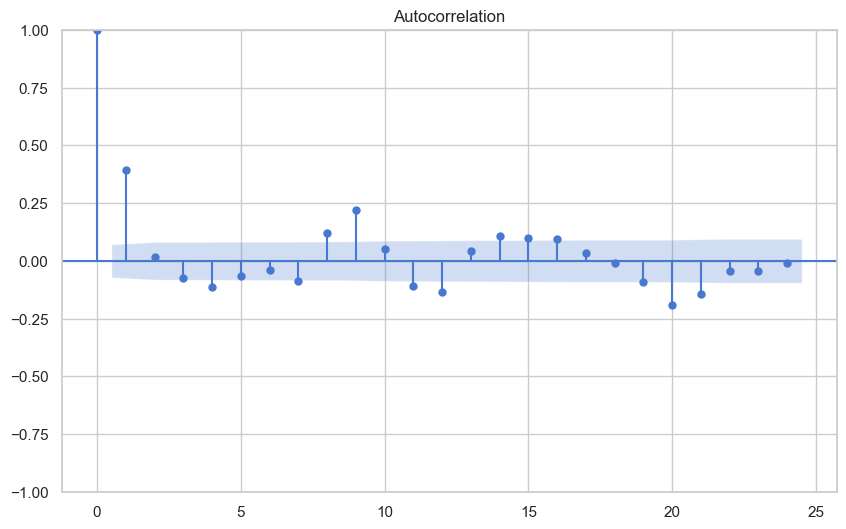

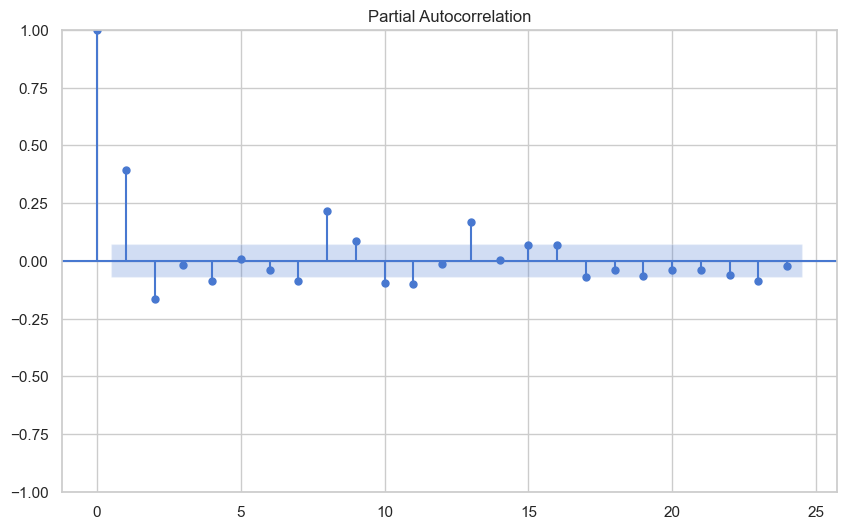

In [78]:
plot_acf(y, lags=24)  
plot_pacf(y, lags=24)  
plt.show()

From the ACF plot, lag 1 shows significant autocorrelation, indicating a strong short-term relationship. There is a gradual decline in autocorrelation after lag 1, suggesting a potential annual pattern, albeit weak. The PACF plot confirms that lag 1 is the most important independent contributor, with minor significance at lags 2 and 6. Beyond lag 6, the partial autocorrelations diminish, indicating limited direct influence from longer lags. Lag 1 should be prioritized as the primary feature in the model.

# Dimensionality Reduction:

## PCA

The PCA Code was adapted from the code provided by Professor C-Y (Eric) NG in the Econ 5060 course. 

In [83]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 1, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 1, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 1    variance explained: 0.152


In [84]:
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,120]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]
    
    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)
    
    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

n_components: 1    variance explained: 0.152
n_components: 2    variance explained: 0.226
n_components: 3    variance explained: 0.297
n_components: 4    variance explained: 0.352
n_components: 5    variance explained: 0.399
n_components: 6    variance explained: 0.435
n_components: 7    variance explained: 0.465
n_components: 8    variance explained: 0.491
n_components: 9    variance explained: 0.512
n_components: 10    variance explained: 0.532
n_components: 11    variance explained: 0.552
n_components: 12    variance explained: 0.570
n_components: 13    variance explained: 0.586
n_components: 14    variance explained: 0.603
n_components: 15    variance explained: 0.619
n_components: 16    variance explained: 0.634
n_components: 17    variance explained: 0.648
n_components: 18    variance explained: 0.661
n_components: 19    variance explained: 0.674
n_components: 20    variance explained: 0.686
n_components: 30    variance explained: 0.788
n_components: 50    variance explained: 0.9

# Model Training and Validation: 

## Define Training, Validation, and Test Sets

In [87]:
train_pct = 0.6
valid_pct = 0.2
test_pct = 0.2

n_train = int(train_pct*len(X))
n_valid = int(valid_pct*len(X))
n_test = len(X)-n_train-n_valid

print(f"Train size: {n_train}, Validation size: {n_valid}, Test size: {n_test}")

Train size: 454, Validation size: 151, Test size: 152


## Grid Search for Optimal Hyperparameters

The Grid Search was mainly adapted from the code provided by Professor C-Y (Eric) NG in the Econ 5060 course. 

In [90]:
def pipeline(config):
    # unpack config
    n_trees, n_comps, learn_rate, reg_alp, reg_lamb = config
    # Steps
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components=n_comps, random_state=1)),
             ('xgboost', XGBRegressor(objective='reg:squarederror', n_estimators=n_trees, 
                                      learning_rate=learn_rate, reg_alpha=reg_alp, reg_lambda=reg_lamb, 
                                      eval_metric='rmse', random_state=1))
            ]
     # Create and return the pipeline
    pipeline = Pipeline(steps)
    return pipeline

In [91]:
def walk_forward_validation(cfg, train_pct=0.6, valid_pct=0.2, test_pct=0.2, window_size=24, step_size=12):
    
    n = len(X)
    n_train = int(train_pct * n) 
    n_valid = int(valid_pct * n)  
    n_test = int(test_pct * n)   
    
  
    X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:n_train+n_valid+n_test]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train+n_valid], y[n_train+n_valid:n_train+n_valid+n_test]

    
    y_pred_list = []
    y_test_list = []

    
    for i in range(n_train, n - n_test - window_size, step_size):  
        
        X_train_window = X[:i]  
        y_train_window = y[:i]
        X_test_window = X[i:i+window_size]  
        y_test_window = y[i:i+window_size]
        

        model = pipeline(cfg).fit(X_train_window, y_train_window)
        

        y_pred = model.predict(X_test_window)

        y_pred_list.extend(y_pred)
        y_test_list.extend(y_test_window)


    mse = mean_squared_error(y_test_list, y_pred_list)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_list, y_pred_list)

    print(f' > MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}')
    return mse, rmse, mae

In [92]:
def repeat_evaluate(config, n_repeats=1):
    key = str(config) 
    
    mse_list = []  
    rmse_list = []
    mae_list = []  
    
    for _ in range(n_repeats):
        mse, rmse, mae = walk_forward_validation(config)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
    

    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)

    print(f'> Model[{key}] Average MSE: {avg_mse:.3f}, Average RMSE: {avg_rmse:.3f}, Average MAE: {avg_mae:.3f}')
    
    return (key, avg_mse, avg_rmse, avg_mae)

In [93]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    
    n_trees = [50,100]  
    n_comps = [5, 6, 7, 8, 9, 10,11,12,13,14,15]  
    learn_rate = [0.05,0.1]  
    reg_alp = [0.5, 1]  
    reg_lamb = [5,10]
    
    # create configs
    configs = list()
    for i in n_trees:
        for j in n_comps:
            for k in learn_rate:
                for l in reg_alp:
                    for m in reg_lamb:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [94]:
# grid search configs
def grid_search(cfg_list):
 
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
  
    scores.sort(key=lambda tup: tup[2])
    return scores

In [95]:
# model configs
cfg_list = model_configs()

Total configs: 176


In [96]:
# grid search
scores = grid_search(cfg_list)
print('done')

 > MSE: 0.063, RMSE: 0.252, MAE: 0.150
> Model[[50, 5, 0.05, 0.5, 5]] Average MSE: 0.063, Average RMSE: 0.252, Average MAE: 0.150
 > MSE: 0.038, RMSE: 0.195, MAE: 0.135
> Model[[50, 5, 0.05, 0.5, 10]] Average MSE: 0.038, Average RMSE: 0.195, Average MAE: 0.135
 > MSE: 0.057, RMSE: 0.240, MAE: 0.146
> Model[[50, 5, 0.05, 1, 5]] Average MSE: 0.057, Average RMSE: 0.240, Average MAE: 0.146
 > MSE: 0.036, RMSE: 0.189, MAE: 0.133
> Model[[50, 5, 0.05, 1, 10]] Average MSE: 0.036, Average RMSE: 0.189, Average MAE: 0.133
 > MSE: 0.093, RMSE: 0.305, MAE: 0.161
> Model[[50, 5, 0.1, 0.5, 5]] Average MSE: 0.093, Average RMSE: 0.305, Average MAE: 0.161
 > MSE: 0.057, RMSE: 0.238, MAE: 0.147
> Model[[50, 5, 0.1, 0.5, 10]] Average MSE: 0.057, Average RMSE: 0.238, Average MAE: 0.147
 > MSE: 0.091, RMSE: 0.301, MAE: 0.157
> Model[[50, 5, 0.1, 1, 5]] Average MSE: 0.091, Average RMSE: 0.301, Average MAE: 0.157
 > MSE: 0.053, RMSE: 0.231, MAE: 0.146
> Model[[50, 5, 0.1, 1, 10]] Average MSE: 0.053, Average 

In [97]:
scores

[('[50, 10, 0.05, 1, 10]',
  0.03316626825629839,
  0.1821160845622879,
  0.1268056035946674),
 ('[50, 11, 0.05, 1, 10]',
  0.035449516250977316,
  0.1882804191916337,
  0.12797853272004323),
 ('[50, 5, 0.05, 1, 10]',
  0.03578164055444086,
  0.18916035672000847,
  0.132783631663646),
 ('[50, 9, 0.05, 1, 10]',
  0.03649860719886564,
  0.19104608658348812,
  0.13156079573258686),
 ('[50, 15, 0.05, 1, 10]',
  0.037212454850993344,
  0.19290530021488095,
  0.1324495100073347),
 ('[50, 10, 0.05, 0.5, 10]',
  0.037295534335411426,
  0.1931205176448412,
  0.12944535863068074),
 ('[50, 9, 0.05, 0.5, 10]',
  0.0374978686049704,
  0.1936436639938689,
  0.1317686900136654),
 ('[50, 5, 0.05, 0.5, 10]',
  0.03802686746892098,
  0.19500478832305881,
  0.13531171801655903),
 ('[50, 13, 0.05, 1, 10]',
  0.03838511767951296,
  0.19592120273087588,
  0.13282865827710888),
 ('[50, 12, 0.05, 1, 10]',
  0.03881547155622315,
  0.1970164245849141,
  0.13562036919772666),
 ('[50, 11, 0.05, 0.5, 10]',
  0.038

After performing grid search, the optimal hyperparameter set is identified, where the selected features (via PCA), number of trees, learning rate, L1 regularization, and L2 regularization are [5, 50, 0.05, 1, 10], as indicated in the first row of the output. Then, retrain the XGBoost model using the optimal hyperparameters [5, 50, 0.05, 1, 10] in the pipeline.

In [99]:
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components=10, random_state=1)),
               ('xgboost', XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, reg_alpha=1, reg_lambda=10, eval_metric='rmse', random_state=1))
              ]

pipeline_final = Pipeline(steps_final)

In [100]:
X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:n_train+n_valid+n_test]
y_train, y_valid, y_test = y[:n_train], y[n_train:n_train+n_valid], y[n_train+n_valid:n_train+n_valid+n_test]

pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=10, random_state=1)),
                ('xgboost',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=1, ...))])

# Performance Evaluation

In [102]:
y_pred = pipeline_final.predict(X_test)

In [103]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5 
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')

Mean Squared Error: 0.027
Root Mean Squared Error: 0.163
Mean Absolute Error: 0.103


The model’s performance, as indicated by RMSE and MAE, demonstrates reasonable predictive accuracy, with RMSE at 0.163 and MAE at 0.103, reflecting small prediction errors in absolute terms. These results suggest that the model performs well in terms of minimizing numerical deviations between predicted and actual values, which is critical for financial forecasting tasks. 

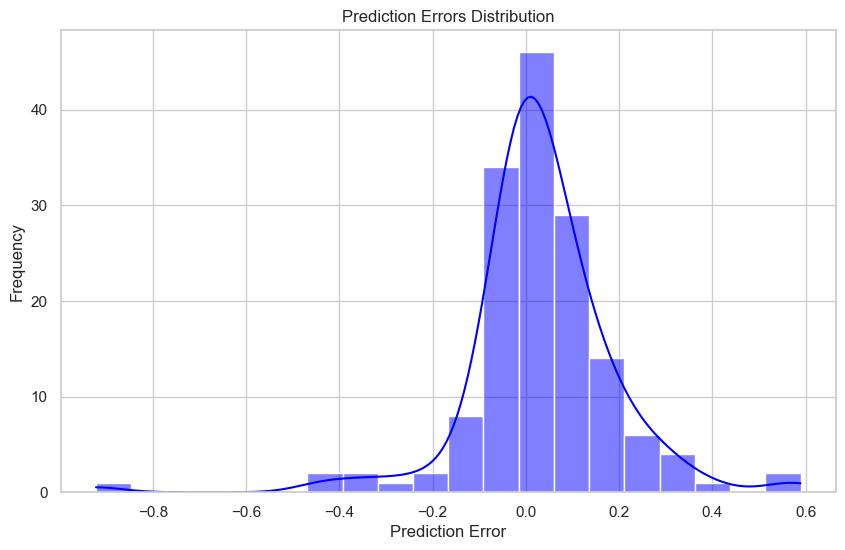

In [105]:
import seaborn as sns

errors = y_test - y_pred


plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='blue', bins=20)
plt.title("Prediction Errors Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

The prediction error distribution indicates that the model performs well overall, with most errors concentrated near zero, demonstrating good accuracy and stability. However, the distribution is slightly left-skewed, suggesting the model may systematically underestimate actual values in certain cases. The error range is approximately -0.8 to 0.6, with the majority falling between -0.2 and 0.2, showing relatively small deviations. The kernel density estimate peaks near zero, reinforcing the model’s accuracy, though the longer left tail highlights potential areas for improvement in addressing extreme underestimations.

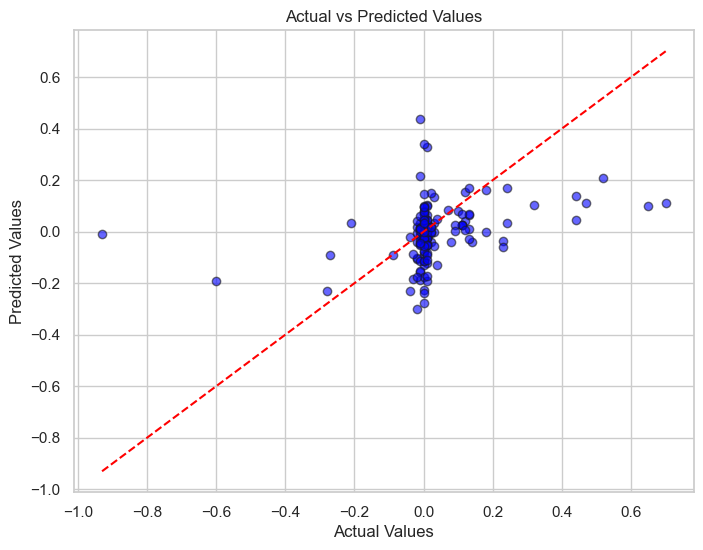

In [107]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 对角线
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

The scatter plot demonstrates that the model performs well overall, with most points concentrated near the ideal prediction line, indicating reliable accuracy for mid-range values (-0.2 to 0.2). However, deviations are observed for extreme actual values (e.g., -1 and 0.6), where the model tends to underestimate or overestimate. These outliers suggest limitations in capturing non-linear relationships or handling extreme cases.

In [109]:
y_pred_df = pd.DataFrame(y_pred, columns=['predicted'], index=y_test.index)


result = pd.concat([y_test, y_pred_df], axis=1)


print(result)

            FEDFUNDS  predicted
sasdate                        
2010-07-01      0.00  -0.115331
2010-08-01      0.01  -0.122797
2010-09-01      0.00  -0.130536
2010-10-01      0.00  -0.092175
2010-11-01      0.00  -0.228028
...              ...        ...
2022-12-01      0.32   0.101571
2023-01-01      0.23  -0.061598
2023-02-01      0.24   0.167553
2023-03-01      0.08  -0.039398
2023-04-01      0.18  -0.000080

[152 rows x 2 columns]


In [110]:
result = result.reset_index()

print(result.columns)

Index(['sasdate', 'FEDFUNDS', 'predicted'], dtype='object')


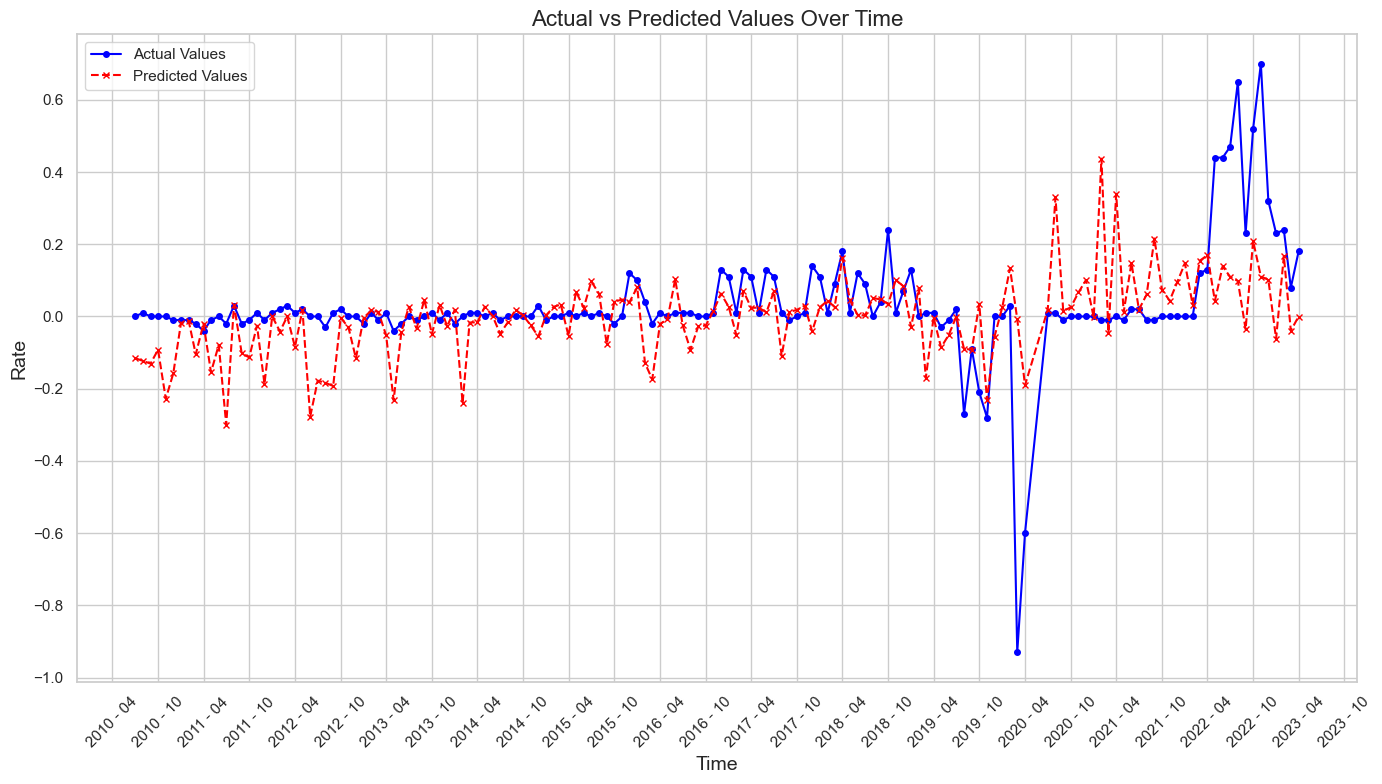

In [111]:
result['sasdate'] = pd.to_datetime(result['sasdate'])

plt.figure(figsize=(14, 8))

plt.plot(result['sasdate'], result['FEDFUNDS'], label='Actual Values', color='blue', linestyle='-', marker='o', markersize=4)

plt.plot(result['sasdate'], result['predicted'], label='Predicted Values', color='red', linestyle='--', marker='x', markersize=4)


plt.title('Actual vs Predicted Values Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rate', fontsize=14)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y - %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval = 6))  


plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()

The time-series plot illustrates the model’s performance over time, comparing actual and predicted values. The model aligns well with actual values during periods of relative stability but exhibits notable deviations during periods of high volatility, particularly around 2020–2021. These discrepancies suggest challenges in capturing rapid or extreme changes in the target variable. 

# Conclusion

The XGBoost model performs well during stable periods, with low RMSE and MAE values indicating reliable accuracy for mid-range trends. However, it struggles during volatile periods, such as 2020–2021, where deviations from actual values highlight limitations in handling abrupt changes. Basically ,further refinements are needed for broader applicability.

# References

Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785–794. https://doi.org/10.1145/2939672.2939785

Eric,C.Y.NG 2024. Data Preprocessiong Section Code, PCA Code and Grid Search Code. Provided as part of the course Econ 5060,The Hong Kong University of Science and Technology.

Box, G. E., Jenkins, G. M., & Reinsel, G. C. (2015). Time Series Analysis: Forecasting and Control. Wiley.